<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/%ED%85%90%EC%B4%8810%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#글쓰는 인공지능 LSTM텍스트 생성

###LSTM:RNN의 발전형태로 장기 기억을 담당하는 셀 스테이트를 갖는 신경망<br/>BOW:데이터셋에 들어있는 단어에 서로 겹치지 않는 고유 번호로 나타낸 집합<br/>희소 표현: 대부분의 숫자가 0인 숫자표현<br/>밀집표현: 대부분의 숫자가 0이 아닌 숫자표현

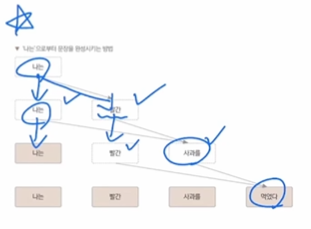

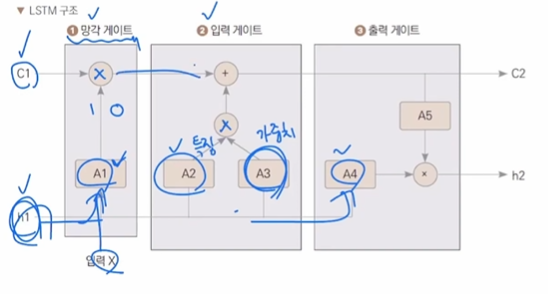

망각게이트:C1이 지금 얼마나 중요한가를 나타내는 게이트(a1의 가중치에 의해 결정)<br/>
입력게이트:셀 상태에 현재정보를 덮어쓸 것인가<br/>
출력게이트:셀 상태와 현재 정보를 합쳐 현재의 은닉 상태를 결정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import string

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CH10/ArticlesApril2017.csv")
print(df.columns)

Index(['abstract', 'articleID', 'articleWordCount', 'byline', 'documentType',
       'headline', 'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


##학습용 데이터 생성

In [3]:
import numpy as np
import glob

from torch.utils.data.dataset import Dataset


class TextGeneration(Dataset):
    def clean_text(self, txt):
        # 모든 단어를 소문자로 바꾸고 특수문자를 제거
        txt = "".join(v for v in txt if v not in string.punctuation).lower()
        return txt
    def __init__(self):
        all_headlines = []

        #모든 헤드라인의 텍스트를 불러옴
        for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/CH10/*.csv"):
            if 'Articles' in filename:
                article_df = pd.read_csv(filename)

                # 데이터셋의 headline의 값을 all_headlines에 추가
                all_headlines.extend(list(article_df.headline.values))
                break

        #빈값제거
        all_headlines = [h for h in all_headlines if h != "Unknown"]

        #구두점 제거 및 전처리가 된 문장들을 리스트로 반환
        self.corpus = [self.clean_text(x) for x in all_headlines]
        self.BOW = {}

        #모든 문장의 단어를 추출해 고유번호 지정
        for line in self.corpus:
            for word in line.split():
                if word not in self.BOW.keys():
                    self.BOW[word] = len(self.BOW.keys())

        # 모델의 입력으로 사용할 데이터
        self.data = self.generate_sequence(self.corpus)

    def generate_sequence(self, txt):
        seq = []

        for line in txt:
            line = line.split()
            line_bow = [self.BOW[word] for word in line]

            # 단어 2개를 입력으로, 그다음 단어를 정답으로
            data = [([line_bow[i], line_bow[i+1]], line_bow[i+2])
            for i in range(len(line_bow)-2)]

            seq.extend(data)

        return seq
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        data = np.array(self.data[i][0])  #입력 데이터
        label = np.array(self.data[i][1]).astype(np.float32)  #출력 데이터

        return data, label

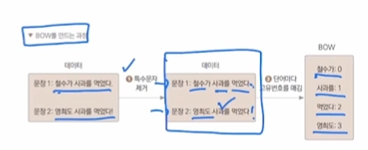

##LSTM모델 정의

In [5]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
   def __init__(self, num_embeddings):
       super(LSTM, self).__init__()

       #밀집표현을 위한 임베딩층
       self.embed = nn.Embedding(
           num_embeddings=num_embeddings, embedding_dim=16)

       #LSTM을 5개층을 쌓음
       self.lstm = nn.LSTM(
           input_size=16,
           hidden_size=64,
           num_layers=5,
           batch_first=True)

       #분류를 위한 MLP층
       self.fc1 = nn.Linear(128, num_embeddings)
       self.fc2 = nn.Linear(num_embeddings,num_embeddings)

       #활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.embed(x)

       #LSTM 모델의 예측값
       x, _ = self.lstm(x)
       x = torch.reshape(x, (x.shape[0], -1))
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       return x

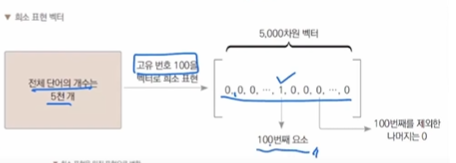

최소표현:100번째 값을 제외한 값이 모두 0

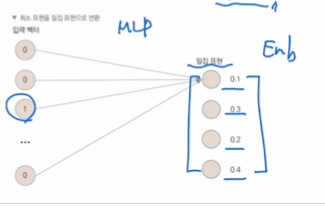

임베딩층이 희소표현인 입력벡터를 밀집표현으로 바꾸어줌

##모델 학습하기

In [7]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

# 학습을 진행할 프로세서 정의
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = TextGeneration()  # 데이터셋 정의
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)  # 모델 정의
loader = DataLoader(dataset, batch_size=64)
optim = Adam(model.parameters(), lr=0.001)

for epoch in range(5): #노트북 너무 느려서 에폭 줄였습니당..
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       # 기울기 초기화
       optim.zero_grad()

       # 모델의 예측값
       pred = model(torch.tensor(data, dtype=torch.long).to(device))

       # 정답 레이블은 long 텐서로 반환해야 함
       loss = nn.CrossEntropyLoss()(
           pred, torch.tensor(label, dtype=torch.long).to(device))

       # 오차 역전파
       loss.backward()
       optim.step()

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "lstm.pth")

  0%|          | 0/104 [00:00<?, ?it/s]<ipython-input-7-cbadc8474c5f>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(data, dtype=torch.long).to(device))
<ipython-input-7-cbadc8474c5f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred, torch.tensor(label, dtype=torch.long).to(device))
epoch4 loss:5.556577205657959: 100%|██████████| 104/104 [00:40<00:00,  2.55it/s]


##성능평가

In [8]:
def generate(model, BOW, string="finding an ", strlen=10):
   device = "cuda" if torch.cuda.is_available() else "cpu"

   print(f"input word: {string}")

   with torch.no_grad():
       for p in range(strlen):
           # 입력 문장을 텐서로 변경
           words = torch.tensor(
               [BOW[w] for w in string.split()], dtype=torch.long).to(device)

           # ❶
           input_tensor = torch.unsqueeze(words[-2:], dim=0)
           output = model(input_tensor)  # 모델을 이용해 예측
           output_word = (torch.argmax(output).cpu().numpy())
           string += list(BOW.keys())[output_word]  # 문장에 예측된 단어를 추가
           string += " "

   print(f"predicted sentence: {string}")

model.load_state_dict(torch.load("lstm.pth", map_location=device))
pred = generate(model, dataset.BOW)

input word: finding an 
predicted sentence: finding an a a a a a a a a a a 


새로운 함수:argmax(A) 텐서A의 최대값이 들어있는 요소의 번호를 반환함